# Team BNP: Data Download, Transformations, and Graphs

Renjie Pan (renjie.pan@nyu.edu)

Tianyu Zhang (tianyuzhang@nyu.edu)

Liang Zou (liazou@nyu.edu)

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Data Transformation

In [2]:
def compute_transformation_series_1(df):
    """
    Perform transformation for positive time series
    Output raw series with absolute delta, percentage change, monthly average, and Z-score
    @param df: Pandas DataFrame (raw time series)
    @return df: Pandas DataFrame (raw time series and transformations)
    """
    N = [1 ,2, 3, 12] 
    for i in N:
        # Compute absolute delta in 1, 2, 3, and 12 months
        df[str(i) + ' month absolute delta'] = pd.to_numeric(df[df.columns[0]]).diff(periods=i)
        # Compute percentage change in 1, 2, 3, and 12 months
        df[str(i) + ' month % change'] = pd.to_numeric(df[df.columns[0]]).pct_change(periods=i)
        
    M = [2, 3, 6, 12]
    for i in M:
        # Compute average in 2, 3, 6, and 12 months
        df[str(i) + ' mo avg'] = pd.to_numeric(df[df.columns[0]]).rolling(i,win_type='triang').sum()
    
    df['6 mo avg - 3 mo avg'] = df['6 mo avg'] - df['3 mo avg']

    def zscore_using_apply(x, window):
        """
        Compute rolling z-score given window size
        @param x: Pandas Series
        @window: integer (window size)
        """
        
        def zscore_func(x):
            """
            Compute z-score of time series
            @param x: Pandas Series
            """
            return (x[-1] - x[:-1].mean())/x[:-1].std(ddof=0)
        
        return x.rolling(window=window+1).apply(zscore_func, raw=False)
    
    Y = [3, 5]
    for i in Y:
        # Compute z-score in 3 and 5 years
        df[str(i) + ' year Z-score'] = zscore_using_apply(pd.to_numeric(df[df.columns[0]]), i * 12)
        
    return df

def compute_transformation_series_2(df):
    """
    Perform transformation for negative time series or percentage
    Output raw series with absolute delta and monthly average
    @param df: Pandas DataFrame (raw time series)
    @return df: Pandas DataFrame (raw time series and transformations)
    """
    N = [1 ,2, 3, 12]
    for i in N:
        # Compute absolute delta in 1, 2, 3, and 12 months
        df[str(i)+' month absolute delta'] = pd.to_numeric(df[df.columns[0]]).diff(periods=i)
    
    M = [2, 3, 6]
    for i in M:
        # Compute average in 2, 3, 6 months
        df[str(i)+' mo avg'] = pd.to_numeric(df[df.columns[0]]).rolling(i,win_type='triang').sum()
        
    df['6 mo avg - 3 mo avg'] = df['6 mo avg'] - df['3 mo avg']
    
    return df

## Plot Transformation

In [3]:
def find_index_end_with(category_str, col_names):
    """
    Find the index of column names that end with specific category
    @param category_str: string (category)
    @param col_names: list of strings (list of column names)
    @return: list of integers (index that ends with specific category)
    """
    index = []
    
    for i, str_val in enumerate(col_names):
        if str_val.endswith(category_str):
            index.append(i)
    
    return index
    
def plot_transformation(df, categories = ['absolute delta', '% change', 'avg', 'Z-score']):
    """
    Plot transformation in different categories (absolute delta, percentage change, avg, and z-score)
    @param df: Pandas DataFrame (transformation time series)
    @param categories: list of strings (category names)
    """
    col_names = df.columns.values
    df.index = pd.to_datetime(df.index)
    
    fig = plt.figure(figsize=(20,30))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i in range(len(categories)):
        index = find_index_end_with(categories[i], col_names)
        ax = fig.add_subplot(len(categories), 1, i+1)
        plt.plot(df.iloc[:,index]);
        plt.legend(col_names[index])
        plt.title(categories[i])
        # plt.xlabel(str(df.index.name))
        plt.xlabel('Year')

### World Oil Production

In [4]:
response = requests.get('http://api.eia.gov/series/?api_key=67b048bfb1a039a3aaca7aa534eba35f&series_id=INTL.53-1-WORL-TBPD.M')
world_oil_production = response.json()['series'][0]['data']
world_oil_production = pd.DataFrame(world_oil_production,columns=['Month','World Oil Production (Thousand Barrels Per Day)'])
world_oil_production['Month'] = pd.to_datetime(world_oil_production['Month'] + '01')

world_oil_production = world_oil_production.set_index('Month')
world_oil_production = world_oil_production.sort_index()
world_oil_production.head()

,World Oil Production (Thousand Barrels Per Day)
Month,
1994-01-01,68475.4
1994-02-01,68207.3
1994-03-01,68126.2
1994-04-01,67773.5
1994-05-01,68141.6


In [5]:
world_oil_production_trans = compute_transformation_series_1(world_oil_production)
world_oil_production_trans.head(10)

,World Oil Production (Thousand Barrels Per Day),1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1994-01-01,68475.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-02-01,68207.3,-268.1,-0.003915,NaN,NaN,NaN,NaN,NaN,NaN,68341.35,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-01,68126.2,-81.1,-0.001189,-349.2,-0.005100,NaN,NaN,NaN,NaN,68166.75,136508.10,NaN,NaN,NaN,NaN,NaN
1994-04-01,67773.5,-352.7,-0.005177,-433.8,-0.006360,-701.9,-0.010250,NaN,NaN,67949.85,136116.60,NaN,NaN,NaN,NaN,NaN
1994-05-01,68141.6,368.1,0.005431,15.4,0.000226,-65.7,-0.000963,NaN,NaN,67957.55,135907.40,NaN,NaN,NaN,NaN,NaN
1994-06-01,68545.5,403.9,0.005927,772.0,0.011391,419.3,0.006155,NaN,NaN,68343.55,136301.10,204261.016667,NaN,67959.916667,NaN,NaN
1994-07-01,68217.5,-328.0,-0.004785,75.9,0.001114,444.0,0.006551,NaN,NaN,68381.50,136725.05,204335.900000,NaN,67610.850000,NaN,NaN
1994-08-01,68087.5,-130.0,-0.001906,-458.0,-0.006682,-54.1,-0.000794,NaN,NaN,68152.50,136534.00,204603.700000,NaN,68069.700000,NaN,NaN
1994-09-01,68752.5,665.0,0.009767,535.0,0.007843,207.0,0.003020,NaN,NaN,68420.00,136572.50,204838.050000,NaN,68265.550000,NaN,NaN


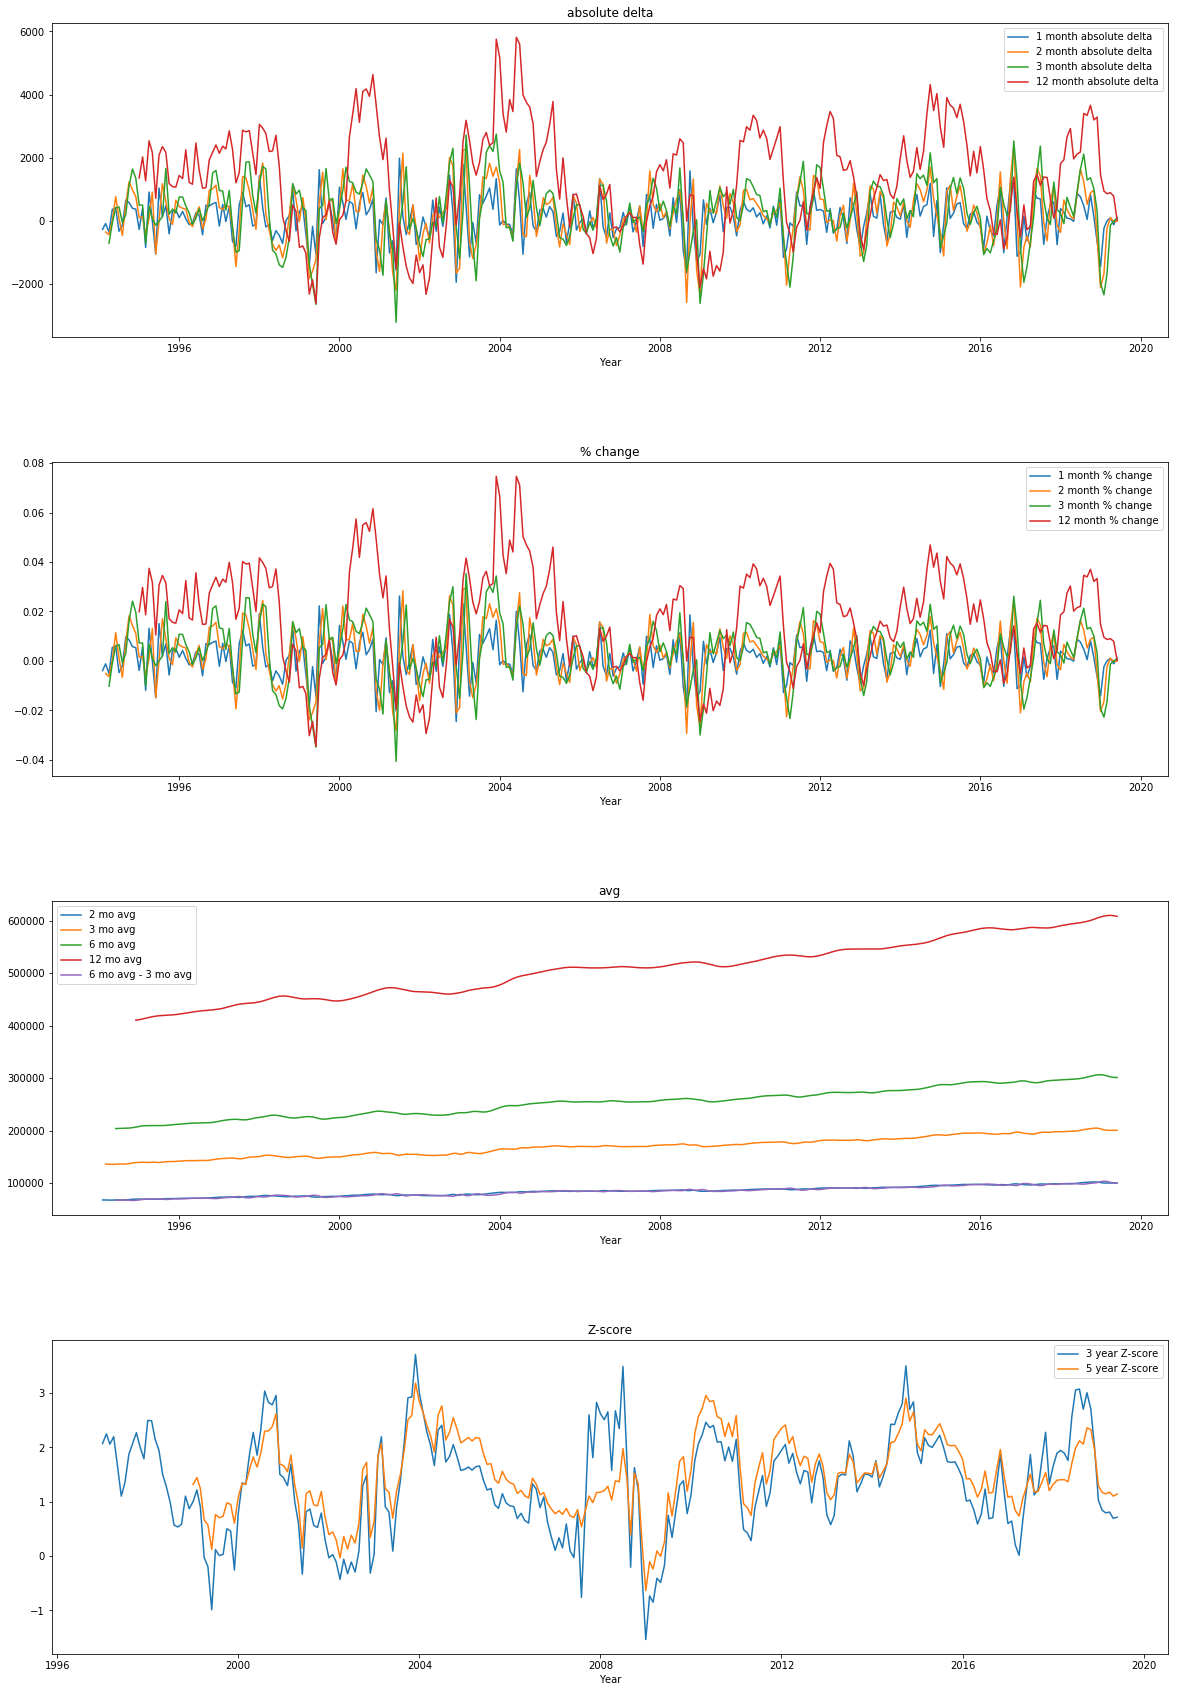

In [6]:
plot_transformation(world_oil_production_trans)

### Daily Oil Price from 2003

In [7]:
response = requests.get('https://www.quandl.com/api/v3/datasets/OPEC/ORB.json?api_key=Hhfh9zqnfy1wcsXRBqGh')
opec_crude_oil_price = response.json()['dataset']['data']
opec_crude_oil_price = pd.DataFrame(opec_crude_oil_price,columns=['Date','OPEC Crude Oil Price'])
opec_crude_oil_price = opec_crude_oil_price.set_index('Date')
opec_crude_oil_price = opec_crude_oil_price.sort_index()
opec_crude_oil_price.index = pd.to_datetime(opec_crude_oil_price.index)
opec_crude_oil_price_M = opec_crude_oil_price.resample('1M').pad()
opec_crude_oil_price_M.head()

,OPEC Crude Oil Price
Date,
2003-01-31,30.71
2003-02-28,32.63
2003-03-31,27.22
2003-04-30,23.72
2003-05-31,26.71


In [8]:
opec_crude_oil_price_M_trans = compute_transformation_series_1(opec_crude_oil_price_M)
opec_crude_oil_price_M_trans.head(10)

,OPEC Crude Oil Price,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Date,,,,,,,,,,,,,,,,
2003-01-31,30.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-28,32.63,1.92,0.062520,NaN,NaN,NaN,NaN,NaN,NaN,31.670,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-31,27.22,-5.41,-0.165798,-3.49,-0.113644,NaN,NaN,NaN,NaN,29.925,61.595,NaN,NaN,NaN,NaN,NaN
2003-04-30,23.72,-3.50,-0.128582,-8.91,-0.273062,-6.99,-0.227613,NaN,NaN,25.470,55.395,NaN,NaN,NaN,NaN,NaN
2003-05-31,26.71,2.99,0.126054,-0.51,-0.018736,-5.92,-0.181428,NaN,NaN,25.215,50.685,NaN,NaN,NaN,NaN,NaN
2003-06-30,27.11,0.40,0.014976,3.39,0.142917,-0.11,-0.004041,NaN,NaN,26.910,52.125,81.756667,NaN,29.631667,NaN,NaN
2003-07-31,27.52,0.41,0.015124,0.81,0.030326,3.80,0.160202,NaN,NaN,27.315,54.225,79.215000,NaN,24.990000,NaN,NaN
2003-08-31,28.90,1.38,0.050145,1.79,0.066027,2.19,0.081992,NaN,NaN,28.210,55.525,79.823333,NaN,24.298333,NaN,NaN
2003-09-30,26.82,-2.08,-0.071972,-0.70,-0.025436,-0.29,-0.010697,NaN,NaN,27.860,56.070,81.753333,NaN,25.683333,NaN,NaN


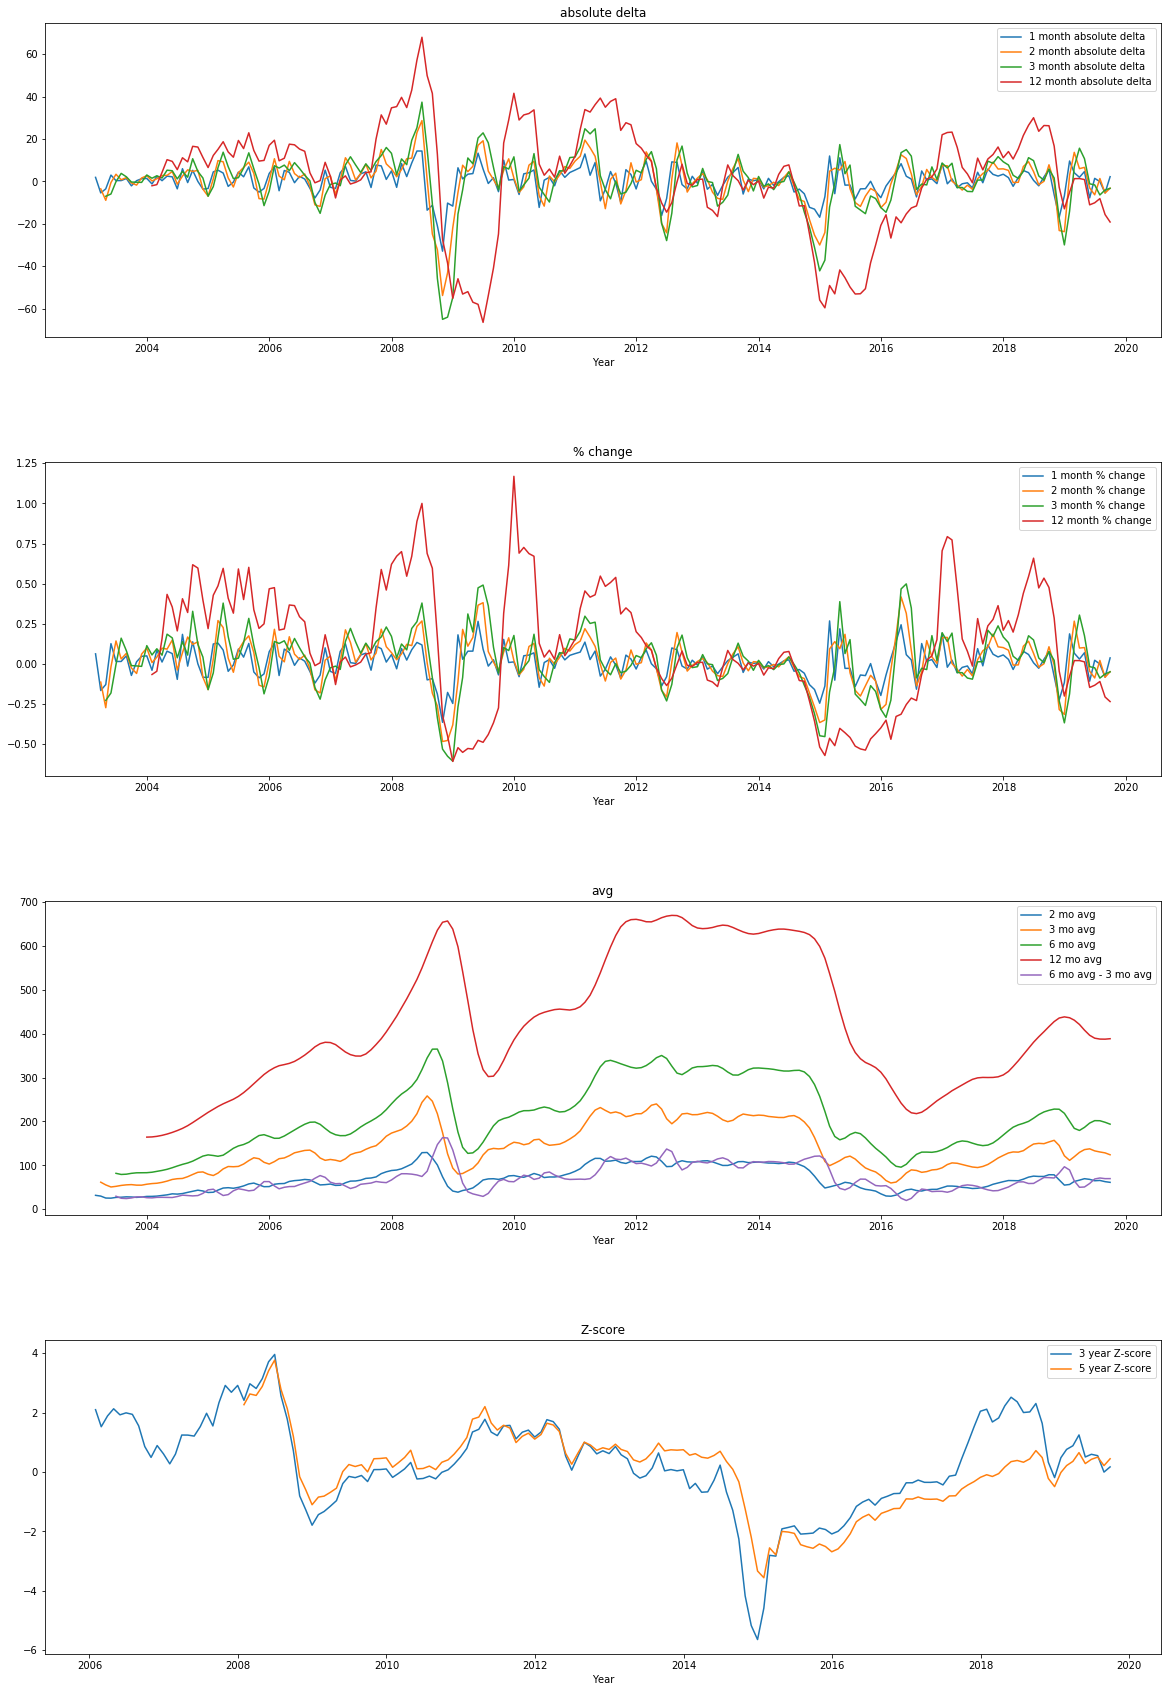

In [9]:
plot_transformation(opec_crude_oil_price_M_trans)

### FRED Data

#### Cass Freight Index: Shipments

In [10]:
response = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=FRGSHPUSM649NCIS&api_key=d5fe2d55e9108db839d9d3ec351de3f9&file_type=json')
shipments = pd.DataFrame(response.json()['observations'])
shipments = shipments.drop(columns = ['realtime_end'])
shipments = shipments.drop(columns = ['realtime_start'])
shipments = shipments.set_index('date')
shipments.apply(pd.to_numeric)
shipments.index.name = 'Month'
shipments = shipments.rename(columns={'value': 'Cass Freight Index: Shipments'})
shipments.head()

,Cass Freight Index: Shipments
Month,
1999-01-01,1.055
1999-02-01,1.070
1999-03-01,1.054
1999-04-01,1.083
1999-05-01,1.038


In [11]:
shipments_trans = compute_transformation_series_1(shipments)
shipments_trans.head(10)

,Cass Freight Index: Shipments,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1999-01-01,1.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-02-01,1.070,0.015,0.014218,NaN,NaN,NaN,NaN,NaN,NaN,1.0625,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-01,1.054,-0.016,-0.014953,-0.001,-0.000948,NaN,NaN,NaN,NaN,1.0620,2.1245,NaN,NaN,NaN,NaN,NaN
1999-04-01,1.083,0.029,0.027514,0.013,0.012150,0.028,0.026540,NaN,NaN,1.0685,2.1305,NaN,NaN,NaN,NaN,NaN
1999-05-01,1.038,-0.045,-0.041551,-0.016,-0.015180,-0.032,-0.029907,NaN,NaN,1.0605,2.1290,NaN,NaN,NaN,NaN,NaN
1999-06-01,1.053,0.015,0.014451,-0.030,-0.027701,-0.001,-0.000949,NaN,NaN,1.0455,2.1060,3.186167,NaN,1.080167,NaN,NaN
1999-07-01,1.041,-0.012,-0.011396,0.003,0.002890,-0.042,-0.038781,NaN,NaN,1.0470,2.0925,3.172833,NaN,1.080333,NaN,NaN
1999-08-01,1.012,-0.029,-0.027858,-0.041,-0.038936,-0.026,-0.025048,NaN,NaN,1.0265,2.0735,3.148833,NaN,1.075333,NaN,NaN
1999-09-01,1.036,0.024,0.023715,-0.005,-0.004803,-0.017,-0.016144,NaN,NaN,1.0240,2.0505,3.123167,NaN,1.072667,NaN,NaN


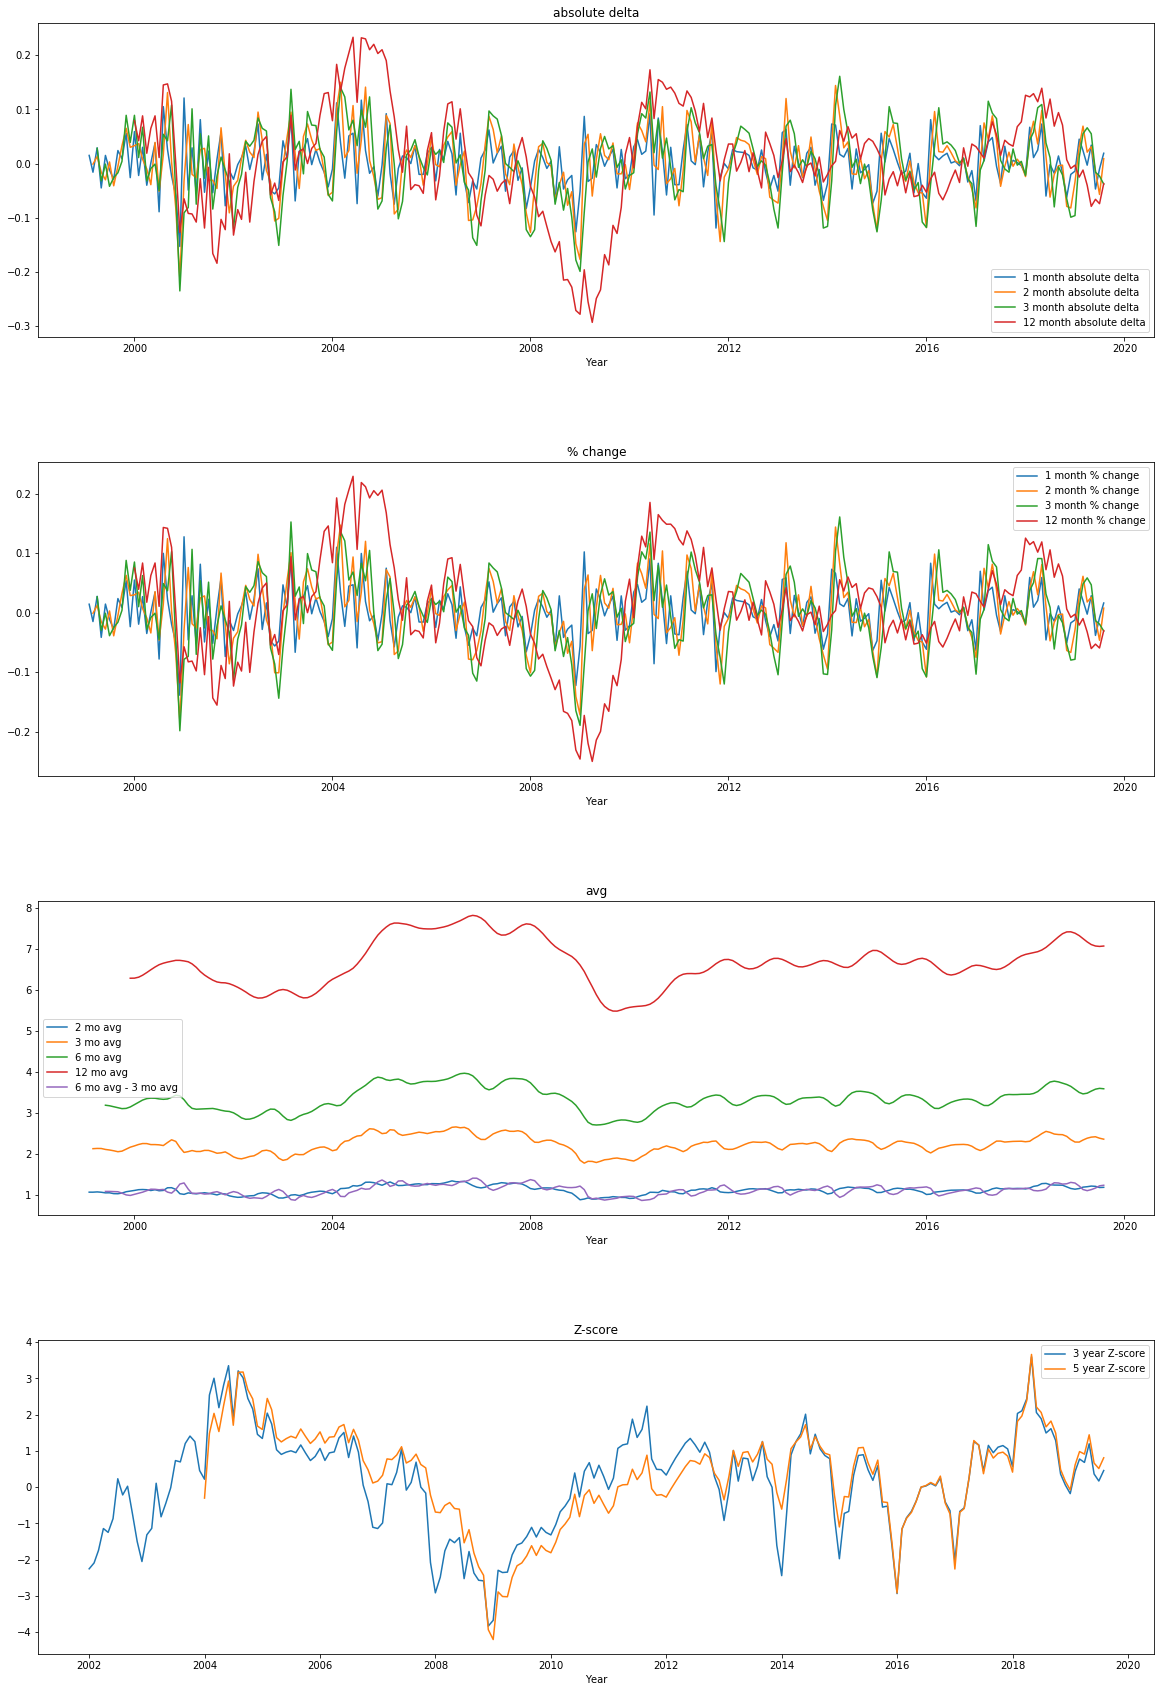

In [12]:
plot_transformation(shipments_trans)

#### Economic Policy Uncertainty Index for Europe

In [13]:
response = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUEPUINDXM&api_key=d5fe2d55e9108db839d9d3ec351de3f9&file_type=json')
euro_uncertainty_index = pd.DataFrame(response.json()['observations'])
euro_uncertainty_index = euro_uncertainty_index.drop(columns = ['realtime_end'])
euro_uncertainty_index = euro_uncertainty_index.drop(columns = ['realtime_start'])
euro_uncertainty_index = euro_uncertainty_index.set_index('date')
euro_uncertainty_index.index.name = 'Month'
euro_uncertainty_index = euro_uncertainty_index.rename(columns={'value': 'Economic Policy Uncertainty Index for Europe'})
euro_uncertainty_index.head()

,Economic Policy Uncertainty Index for Europe
Month,
1987-01-01,57.10735
1987-02-01,49.24059
1987-03-01,79.67975
1987-04-01,63.25882
1987-05-01,47.48835


In [14]:
euro_uncertainty_index_trans = compute_transformation_series_1(euro_uncertainty_index)
euro_uncertainty_index_trans.head(10)

,Economic Policy Uncertainty Index for Europe,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1987-01-01,57.10735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-02-01,49.24059,-7.86676,-0.137754,NaN,NaN,NaN,NaN,NaN,NaN,53.173970,NaN,NaN,NaN,NaN,NaN,NaN
1987-03-01,79.67975,30.43916,0.618172,22.57240,0.395263,NaN,NaN,NaN,NaN,64.460170,117.634140,NaN,NaN,NaN,NaN,NaN
1987-04-01,63.25882,-16.42093,-0.206087,14.01823,0.284689,6.15147,0.107718,NaN,NaN,71.469285,135.929455,NaN,NaN,NaN,NaN,NaN
1987-05-01,47.48835,-15.77047,-0.249301,-32.19140,-0.404010,-1.75224,-0.035585,NaN,NaN,55.373585,126.842870,NaN,NaN,NaN,NaN,NaN
1987-06-01,71.71052,24.22217,0.510066,8.45170,0.133605,-7.96923,-0.100016,NaN,NaN,59.599435,114.973020,188.949590,NaN,73.976570,NaN,NaN
1987-07-01,33.79103,-37.91949,-0.528786,-13.69732,-0.288435,-29.46779,-0.465829,NaN,NaN,52.750775,112.350210,181.823047,NaN,69.472837,NaN,NaN
1987-08-01,37.78870,3.99767,0.118306,-33.92182,-0.473038,-9.69965,-0.204253,NaN,NaN,35.789865,88.540640,167.435392,NaN,78.894752,NaN,NaN
1987-09-01,35.24237,-2.54633,-0.067383,1.45134,0.042950,-36.46815,-0.508547,NaN,NaN,36.515535,72.305400,146.973348,NaN,74.667948,NaN,NaN


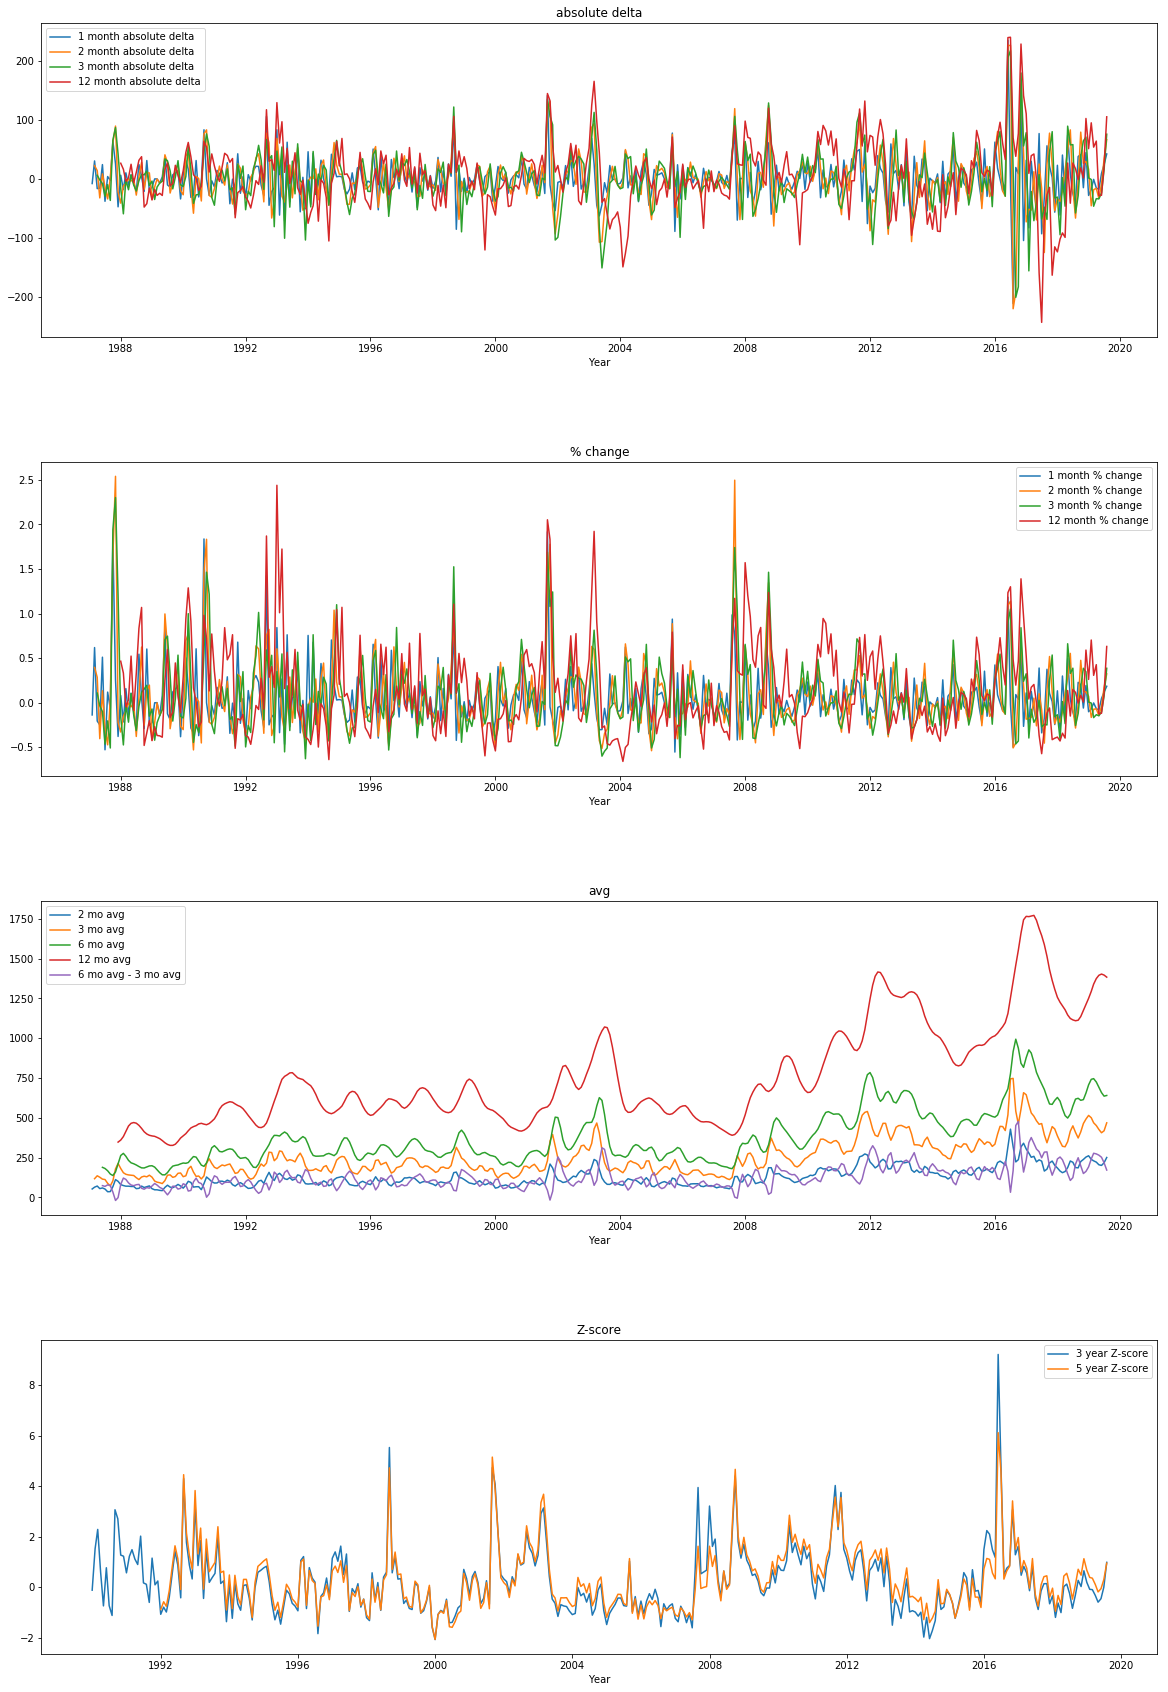

In [15]:
plot_transformation(euro_uncertainty_index_trans)

#### Economic Policy Uncertainty Index for Germany

In [16]:
response = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=DEEPUINDXM&api_key=d5fe2d55e9108db839d9d3ec351de3f9&file_type=json')
ger_uncertainty_index = pd.DataFrame(response.json()['observations'])
ger_uncertainty_index = ger_uncertainty_index.drop(columns = ['realtime_end'])
ger_uncertainty_index = ger_uncertainty_index.drop(columns = ['realtime_start'])
ger_uncertainty_index = ger_uncertainty_index.set_index('date')
ger_uncertainty_index.index.name = 'Month'
ger_uncertainty_index = ger_uncertainty_index.rename(columns={'value': 'Economic Policy Uncertainty Index for Germany'})
ger_uncertainty_index.head()

,Economic Policy Uncertainty Index for Germany
Month,
1993-01-01,178.75275
1993-02-01,114.21303
1993-03-01,139.10310
1993-04-01,56.50121
1993-05-01,120.82400


In [17]:
ger_uncertainty_index_trans = compute_transformation_series_1(ger_uncertainty_index)
ger_uncertainty_index_trans.head(10)

,Economic Policy Uncertainty Index for Germany,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1993-01-01,178.75275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,114.21303,-64.53972,-0.361056,NaN,NaN,NaN,NaN,NaN,NaN,146.482890,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-01,139.10310,24.89007,0.217927,-39.64965,-0.221813,NaN,NaN,NaN,NaN,126.658065,273.140955,NaN,NaN,NaN,NaN,NaN
1993-04-01,56.50121,-82.60189,-0.593818,-57.71182,-0.505300,-122.25154,-0.683914,NaN,NaN,97.802155,224.460220,NaN,NaN,NaN,NaN,NaN
1993-05-01,120.82400,64.32279,1.138432,-18.27910,-0.131407,6.61097,0.057883,NaN,NaN,88.662605,186.464760,NaN,NaN,NaN,NaN,NaN
1993-06-01,88.19376,-32.63024,-0.270064,31.69255,0.560918,-50.90934,-0.365983,NaN,NaN,104.508880,193.171485,325.013192,NaN,131.841707,NaN,NaN
1993-07-01,97.81392,9.62016,0.109080,-23.01008,-0.190443,41.31271,0.731183,NaN,NaN,93.003840,197.512720,296.757263,NaN,99.244543,NaN,NaN
1993-08-01,123.00512,25.19120,0.257542,34.81136,0.394715,2.18112,0.018052,NaN,NaN,110.409520,203.413360,295.023735,NaN,91.610375,NaN,NaN
1993-09-01,170.83865,47.83353,0.388874,73.02473,0.746568,82.64489,0.937083,NaN,NaN,146.921885,257.331405,314.810937,NaN,57.479532,NaN,NaN


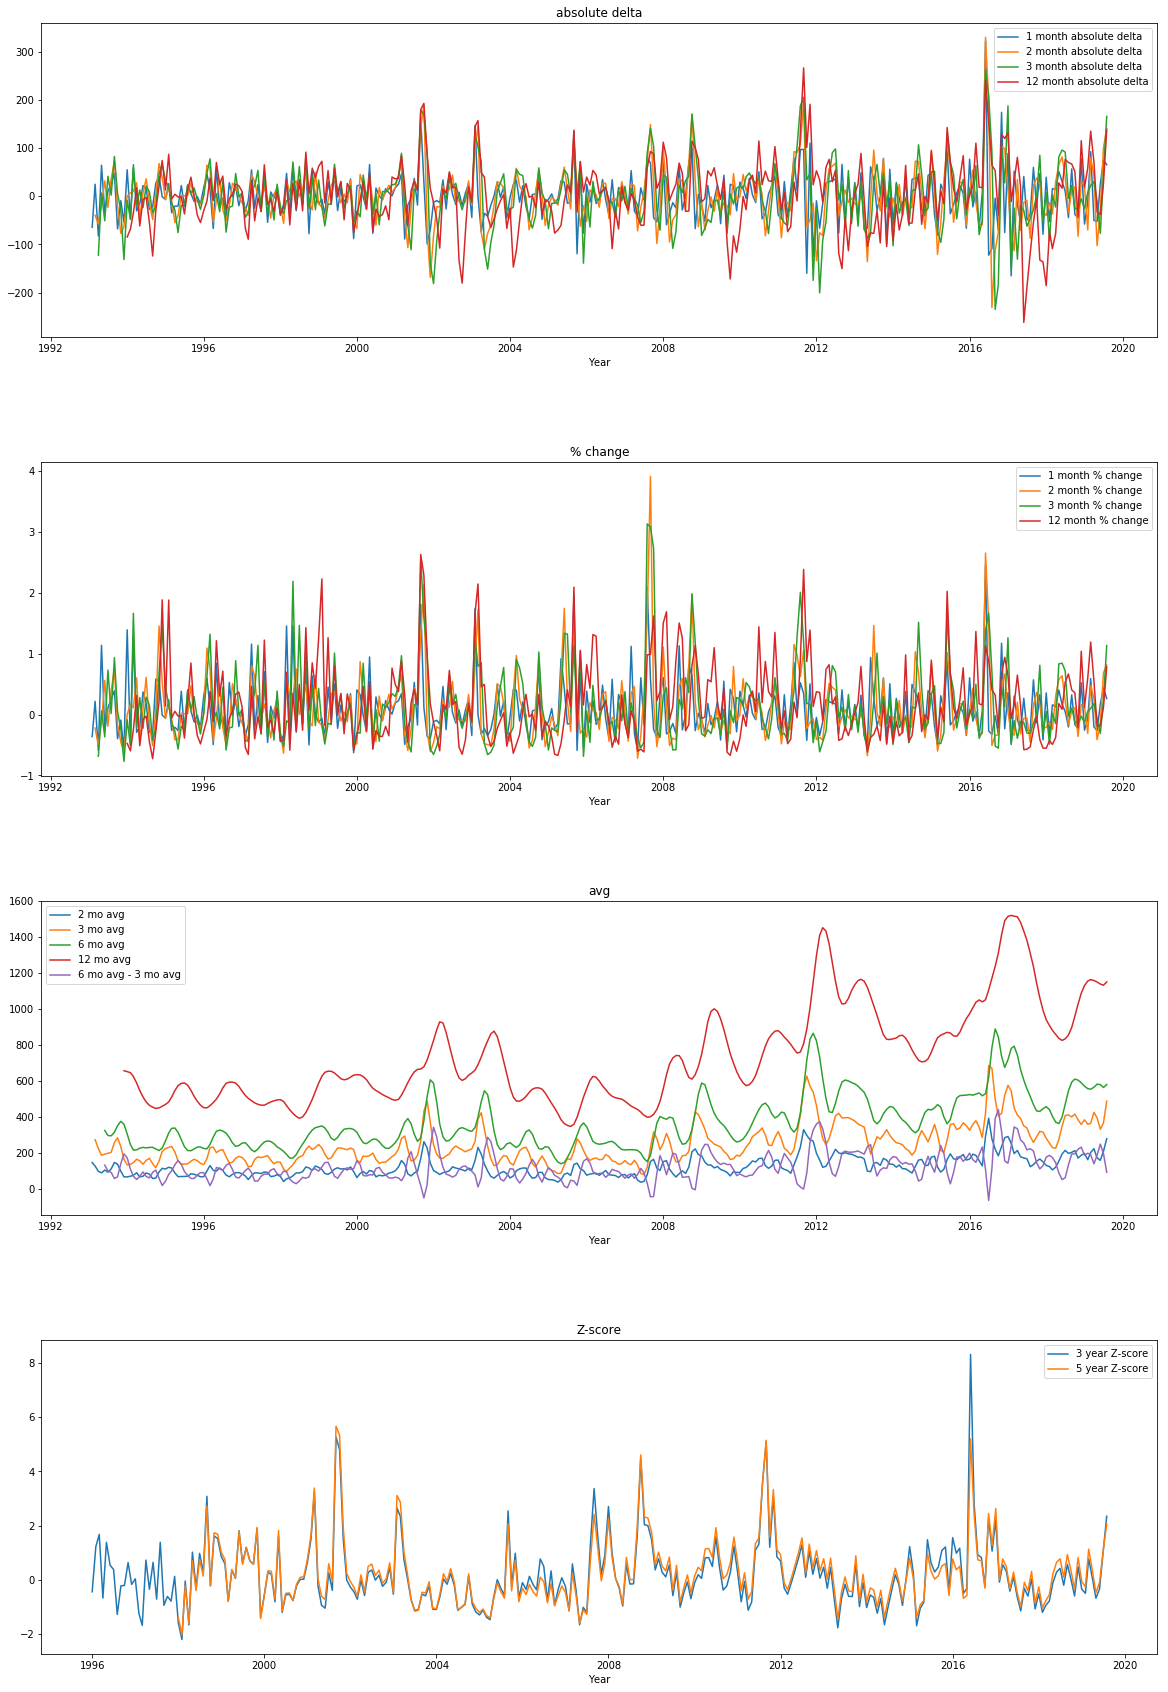

In [18]:
plot_transformation(ger_uncertainty_index_trans)

#### Consumer Opinion Surveys: Confidence Indicators: Composite Indicators: OECD Indicator for the Euro Area

In [19]:
response = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=CSCICP03EZM665S&api_key=d5fe2d55e9108db839d9d3ec351de3f9&file_type=json')
euro_oecd_indicator = pd.DataFrame(response.json()['observations'])
euro_oecd_indicator = euro_oecd_indicator.drop(columns = ['realtime_end'])
euro_oecd_indicator = euro_oecd_indicator.drop(columns = ['realtime_start'])
euro_oecd_indicator = euro_oecd_indicator.set_index('date')
euro_oecd_indicator.index.name = 'Month'
euro_oecd_indicator = euro_oecd_indicator.rename(columns={'value': 'OECD Indicator for the Euro Area'})
euro_oecd_indicator.head()

,OECD Indicator for the Euro Area
Month,
1973-01-01,103.251461492081
1973-02-01,102.86843190004
1973-03-01,102.428000555609
1973-04-01,101.980161779698
1973-05-01,101.653977277055


In [20]:
euro_oecd_indicator_trans = compute_transformation_series_1(euro_oecd_indicator)
euro_oecd_indicator_trans.head(10)

,OECD Indicator for the Euro Area,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1973-01-01,103.251461492081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-01,102.86843190004,-0.383030,-0.003710,NaN,NaN,NaN,NaN,NaN,NaN,103.059947,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-01,102.428000555609,-0.440431,-0.004282,-0.823461,-0.007975,NaN,NaN,NaN,NaN,102.648216,205.708163,NaN,NaN,NaN,NaN,NaN
1973-04-01,101.980161779698,-0.447839,-0.004372,-0.888270,-0.008635,-1.271300,-0.012313,NaN,NaN,102.204081,204.852297,NaN,NaN,NaN,NaN,NaN
1973-05-01,101.653977277055,-0.326185,-0.003199,-0.774023,-0.007557,-1.214455,-0.011806,NaN,NaN,101.817070,204.021151,NaN,NaN,NaN,NaN,NaN
1973-06-01,101.500918532926,-0.153059,-0.001506,-0.479243,-0.004699,-0.927082,-0.009051,NaN,NaN,101.577448,203.394517,306.726737,NaN,103.332219,NaN,NaN
1973-07-01,101.451183245431,-0.049735,-0.000490,-0.202794,-0.001995,-0.528979,-0.005187,NaN,NaN,101.476051,203.053499,305.712845,NaN,102.659346,NaN,NaN
1973-08-01,101.418395850814,-0.032787,-0.000323,-0.082523,-0.000813,-0.235581,-0.002317,NaN,NaN,101.434790,202.910840,304.985818,NaN,102.074978,NaN,NaN
1973-09-01,101.338759537702,-0.079636,-0.000785,-0.112424,-0.001108,-0.162159,-0.001598,NaN,NaN,101.378578,202.813367,304.549425,NaN,101.736058,NaN,NaN


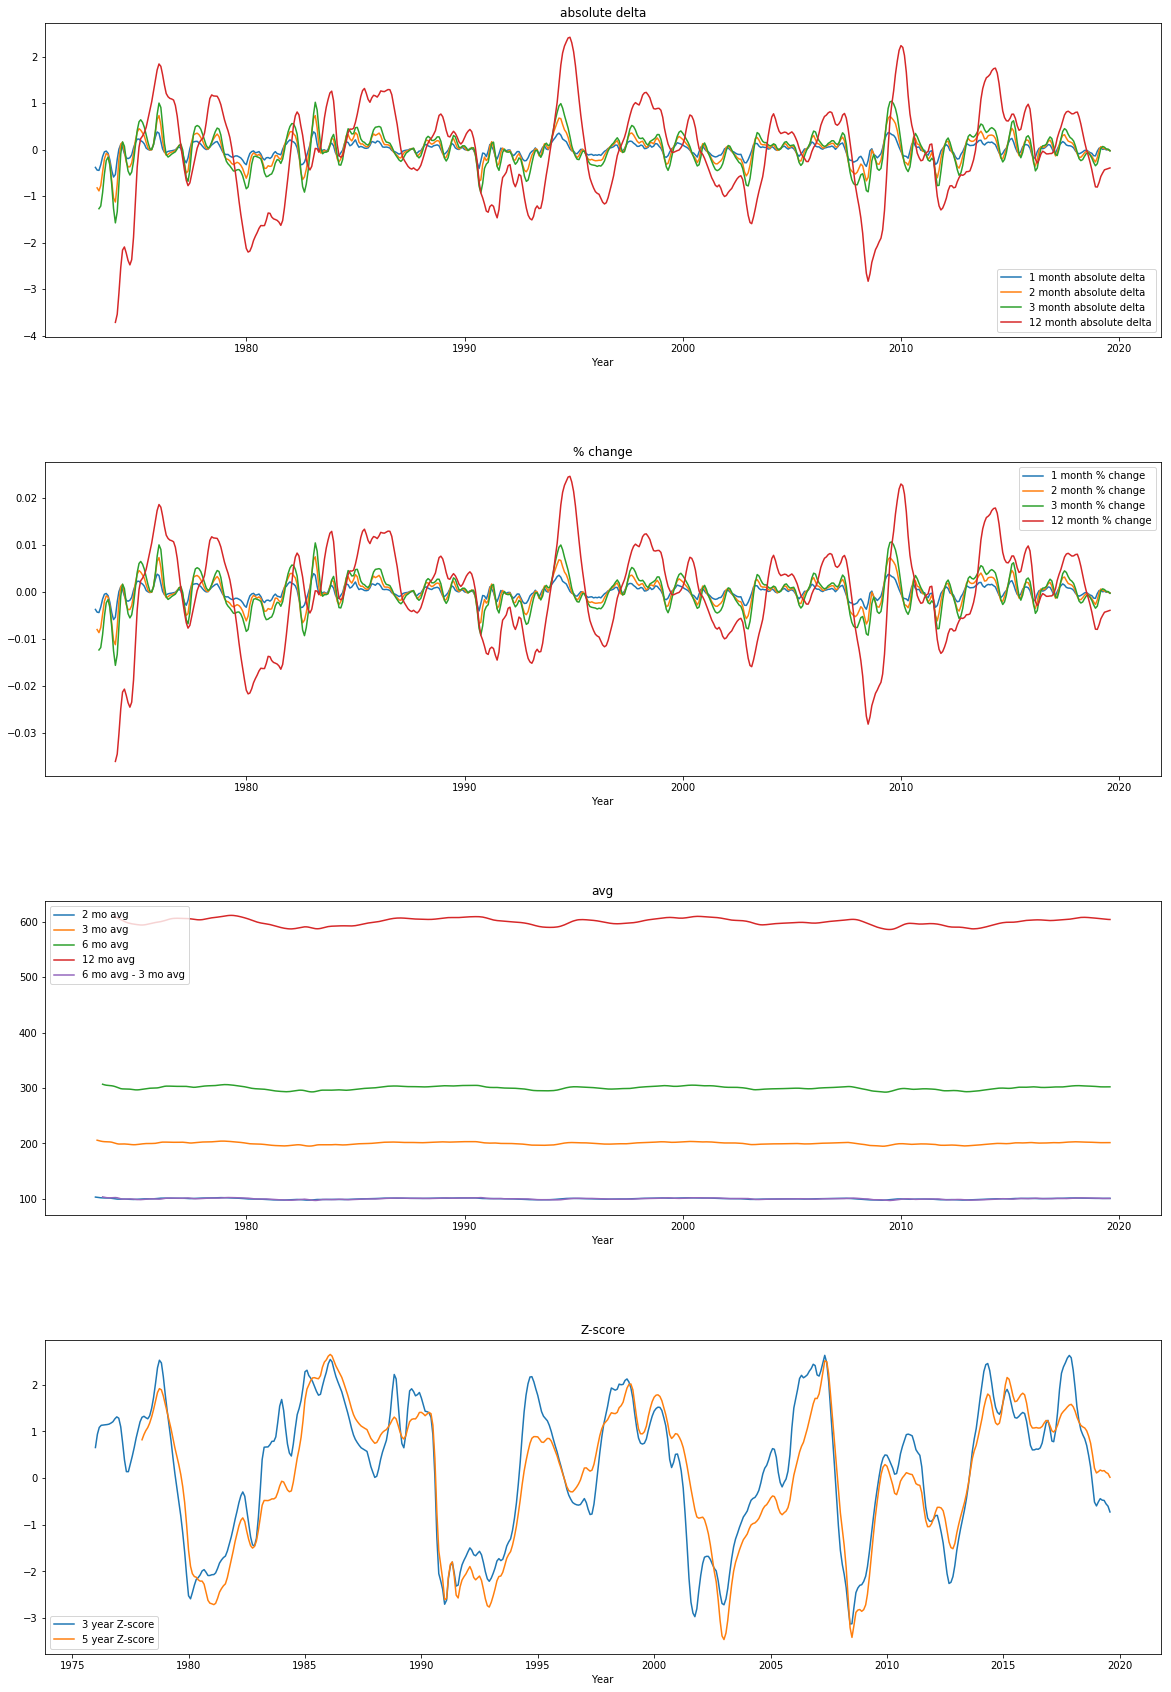

In [21]:
plot_transformation(euro_oecd_indicator_trans)

#### Leading Index for the United States

In [22]:
response = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=CSCICP03EZM665S&api_key=d5fe2d55e9108db839d9d3ec351de3f9&file_type=json')
us_leading_index = pd.DataFrame(response.json()['observations'])
us_leading_index = us_leading_index.drop(columns = ['realtime_end'])
us_leading_index = us_leading_index.drop(columns = ['realtime_start'])
us_leading_index = us_leading_index.set_index('date')
us_leading_index.index.name = 'Month'
us_leading_index = us_leading_index.rename(columns={'value': 'Leading Index for the United States'})
us_leading_index.head()

,Leading Index for the United States
Month,
1973-01-01,103.251461492081
1973-02-01,102.86843190004
1973-03-01,102.428000555609
1973-04-01,101.980161779698
1973-05-01,101.653977277055


In [23]:
us_leading_index_trans = compute_transformation_series_1(us_leading_index)
us_leading_index_trans.head(10)

,Leading Index for the United States,1 month absolute delta,1 month % change,2 month absolute delta,2 month % change,3 month absolute delta,3 month % change,12 month absolute delta,12 month % change,2 mo avg,3 mo avg,6 mo avg,12 mo avg,6 mo avg - 3 mo avg,3 year Z-score,5 year Z-score
Month,,,,,,,,,,,,,,,,
1973-01-01,103.251461492081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-01,102.86843190004,-0.383030,-0.003710,NaN,NaN,NaN,NaN,NaN,NaN,103.059947,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-01,102.428000555609,-0.440431,-0.004282,-0.823461,-0.007975,NaN,NaN,NaN,NaN,102.648216,205.708163,NaN,NaN,NaN,NaN,NaN
1973-04-01,101.980161779698,-0.447839,-0.004372,-0.888270,-0.008635,-1.271300,-0.012313,NaN,NaN,102.204081,204.852297,NaN,NaN,NaN,NaN,NaN
1973-05-01,101.653977277055,-0.326185,-0.003199,-0.774023,-0.007557,-1.214455,-0.011806,NaN,NaN,101.817070,204.021151,NaN,NaN,NaN,NaN,NaN
1973-06-01,101.500918532926,-0.153059,-0.001506,-0.479243,-0.004699,-0.927082,-0.009051,NaN,NaN,101.577448,203.394517,306.726737,NaN,103.332219,NaN,NaN
1973-07-01,101.451183245431,-0.049735,-0.000490,-0.202794,-0.001995,-0.528979,-0.005187,NaN,NaN,101.476051,203.053499,305.712845,NaN,102.659346,NaN,NaN
1973-08-01,101.418395850814,-0.032787,-0.000323,-0.082523,-0.000813,-0.235581,-0.002317,NaN,NaN,101.434790,202.910840,304.985818,NaN,102.074978,NaN,NaN
1973-09-01,101.338759537702,-0.079636,-0.000785,-0.112424,-0.001108,-0.162159,-0.001598,NaN,NaN,101.378578,202.813367,304.549425,NaN,101.736058,NaN,NaN


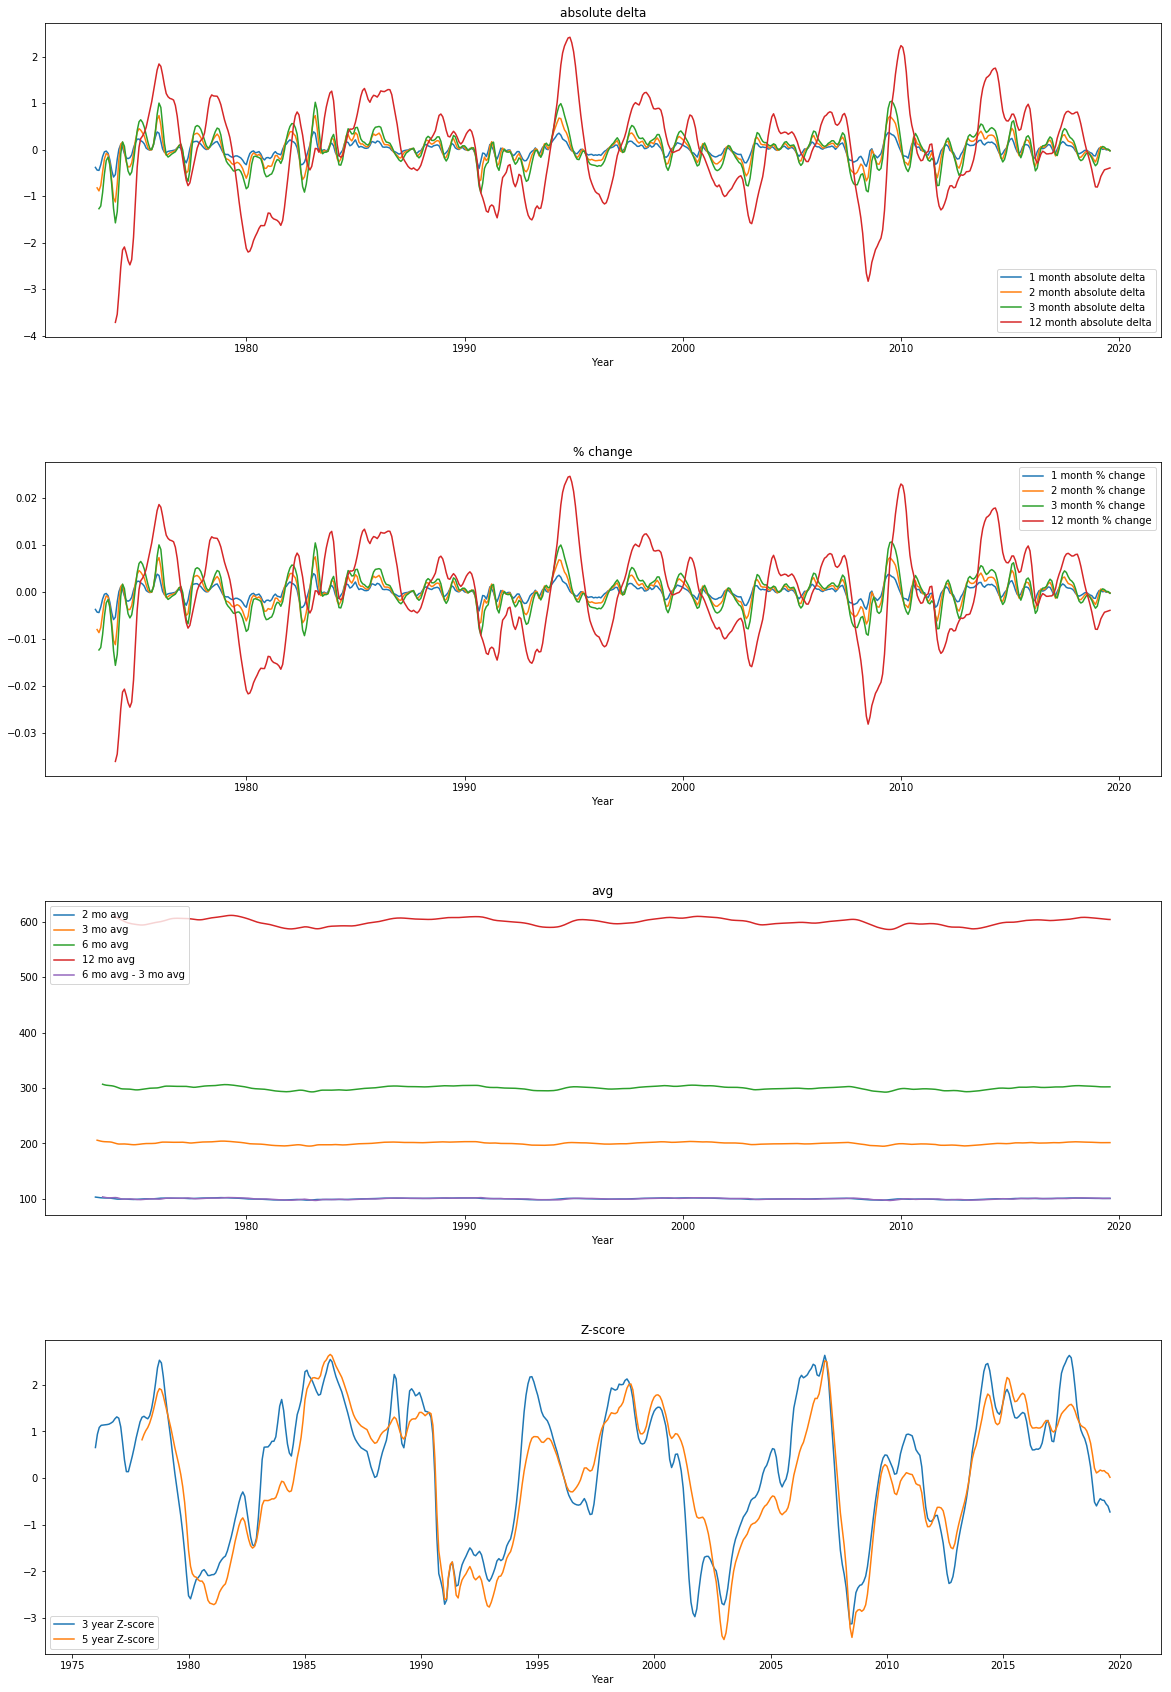

In [24]:
plot_transformation(us_leading_index_trans)